## Taiyō - Machine Learning Assignment
### Time-Series Analysis

Feature Importance- Dynamic Time Warping and/or XGBoost/Shapley Value hybrid model approach to quantify which factors influence the target positively or negative<br>
Dataset used: [Investing.com](http://investing.com/)<br>

In [1]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn import metrics

In [2]:
#Load the dataset
df=pd.read_csv("Crude Oil WTI Futures Historical Data.csv",header=0)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 14, 2022",122.41,120.59,123.66,120.39,-,1.22%
1,"Jun 13, 2022",120.93,120.19,122.25,117.47,372.40K,0.22%
2,"Jun 10, 2022",120.67,121.46,122.75,118.33,352.91K,-0.69%
3,"Jun 09, 2022",121.51,122.43,122.72,120.79,293.30K,-0.49%
4,"Jun 08, 2022",122.11,119.79,123.18,119.30,340.59K,2.26%
...,...,...,...,...,...,...,...
114,"Jan 07, 2022",75.91,76.74,77.00,75.69,18.25K,-0.49%
115,"Jan 06, 2022",76.28,74.57,76.80,74.10,23.04K,1.29%
116,"Jan 05, 2022",75.31,74.91,75.90,74.40,24.74K,0.49%
117,"Jan 04, 2022",74.94,73.88,75.40,73.70,25.34K,1.28%


In [3]:
#Number of rows and columns in the dataset
df.shape

(119, 7)

In [4]:
#Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      119 non-null    object 
 1   Price     119 non-null    float64
 2   Open      119 non-null    float64
 3   High      119 non-null    float64
 4   Low       119 non-null    float64
 5   Vol.      119 non-null    object 
 6   Change %  119 non-null    object 
dtypes: float64(4), object(3)
memory usage: 6.6+ KB


In [5]:
#Converting string datatype into datetime datatype
df['Date']=pd.to_datetime(df['Date'])

In [6]:
#Removing 'K' from Vol.
df['Vol.']=df['Vol.'].str[:-1]

#Replacing '' values with '0'
df['Vol.'] = df['Vol.'].replace([''],'0')

#Converting string datatype into float datatype
df['Vol.']=df['Vol.'].astype('float')

In [7]:
#Removing '%' from Change %
df['Change %']=df['Change %'].str[:-1]

#Converting string datatype into float datatype
df['Change %']=df['Change %'].astype('float')

In [8]:
#Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      119 non-null    datetime64[ns]
 1   Price     119 non-null    float64       
 2   Open      119 non-null    float64       
 3   High      119 non-null    float64       
 4   Low       119 non-null    float64       
 5   Vol.      119 non-null    float64       
 6   Change %  119 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 6.6 KB


In [9]:
#Check for missing/null values
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

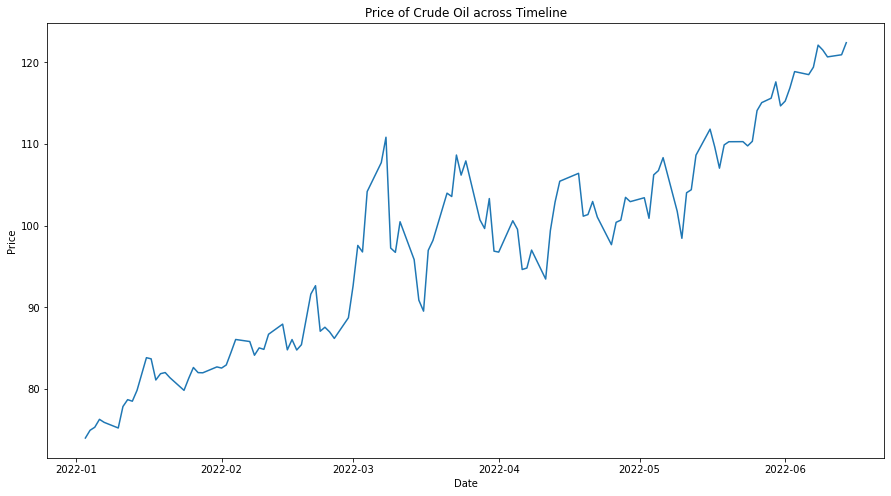

In [10]:
plt.figure(figsize=(15,8))
plt.title('Price of Crude Oil across Timeline')
plt.plot(df.Date,df.Price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Inference: From the graph, we can infer that the price of crude oil has significantly increased over the past six months.

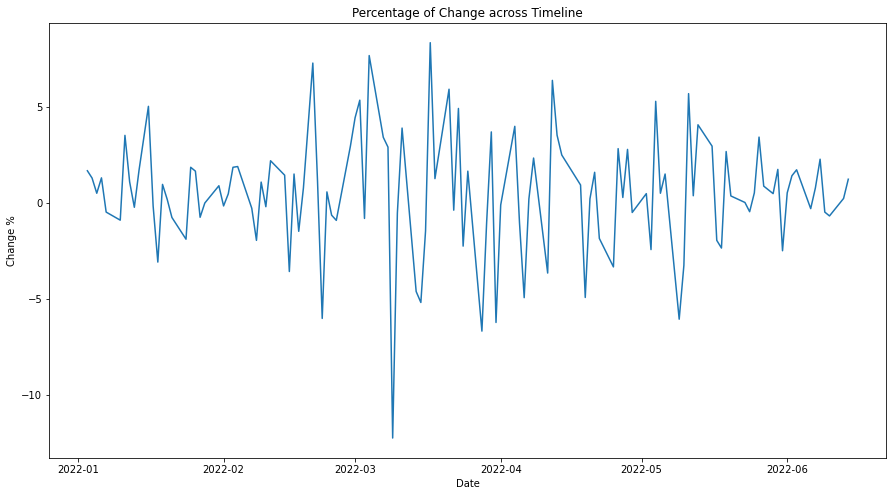

In [11]:
plt.figure(figsize=(15,8))
plt.title('Percentage of Change across Timeline')
plt.plot(df['Date'],df['Change %'])
plt.xlabel('Date')
plt.ylabel('Change %')
plt.show()

Inference: From the graph, we can see that there has been a steep decline in change % during the beginning of March and similarly a steep incline in change % by the middle of March. We can also infer that Change % is not consistent; it always keeps increasing and decreasing across the six months.

In [12]:
#Setting Date to be the index of dataframe
df=df.set_index(['Date'])

Splitting the Data into Training Data and Test Data

In [13]:
d=df.drop(['Open','High','Low','Vol.','Change %'],axis=1)
testdata=d.iloc[:30,:]
traindata=d.iloc[30:,:]

In [14]:
traindata

,Price
Date,
2022-05-04,106.22
2022-05-03,100.90
2022-05-02,103.42
2022-04-29,102.94
2022-04-28,103.47
...,...
2022-01-07,75.91
2022-01-06,76.28
2022-01-05,75.31


In [15]:
testdata

,Price
Date,
2022-06-14,122.41
2022-06-13,120.93
2022-06-10,120.67
2022-06-09,121.51
2022-06-08,122.11
2022-06-07,119.41
2022-06-06,118.50
2022-06-03,118.87
2022-06-02,116.87


### XGBoost Feature Selection

In [16]:
def feature_selection(data,label=None):
    data['Date']=data.index
    data['Day of Week']=data['Date'].dt.dayofweek
    data['Month']=data['Date'].dt.month
    data['Year']=data['Date'].dt.year
    data['Day of Year']=data['Date'].dt.dayofyear
    data['Day of Month']=data['Date'].dt.day
    X=data[['Day of Week','Month','Year','Day of Year','Day of Month']]
    if label:
        Y=data[label]
        return X,Y
    return X

In [17]:
%%capture
X_train,Y_train=feature_selection(traindata,label='Price')
X_test,Y_test=feature_selection(testdata,label='Price')

In [18]:
print(X_train.shape,X_test.shape)

(89, 5) (30, 5)


In [19]:
model=XGBRegressor(n_estimators=1000)

In [20]:
model.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

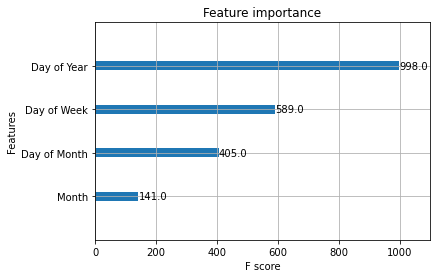

In [21]:
#Plotting feature importance
plot_importance(model)
plt.rcParams["figure.figsize"]=(8,8)
plt.show()

Inference: It is clear from the graph that the 'Day of Year' feature is the most important with an F-score of 998 while 'Month' has the least importance with an F-score of 141.

### Making Predictions using XGBoost

In [22]:
%%capture
testdata['Predicted_Price']=model.predict(X_test)
new_data=pd.concat([testdata,traindata])

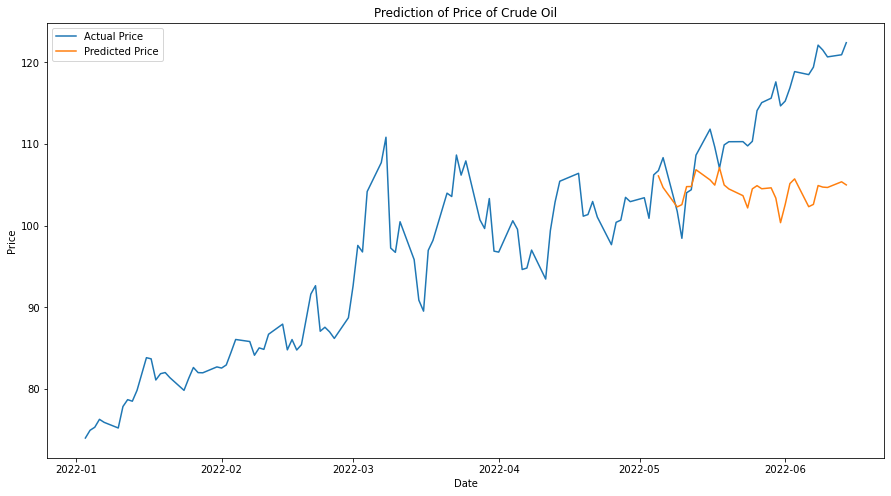

In [23]:
plt.figure(figsize=(15,8))
plt.title('Prediction of Price of Crude Oil')
plt.plot(new_data.Price)
plt.plot(new_data.Predicted_Price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Actual Price','Predicted Price'])
plt.show()

Inference: Here the price is predicted for the last one month, which shows to be in the range 100-110, while the actual price goes up to 120.